<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/Hugo_Abonizio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [5]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [6]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

class DataLoader:
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    if shuffle:
      self.indices = torch.randperm(len(dataset))
    else:
      self.indices = torch.tensor(range(len(dataset)))
  
  def __len__(self):
    return len(self.dataset) // self.batch_size
  
  def __iter__(self):
    self.counter = 0
    return self
  
  def __next__(self):
    if self.counter >= len(self):
      raise StopIteration

    batch_indices = self.indices[self.counter*self.batch_size:self.counter*self.batch_size+self.batch_size]
    batch = torch.utils.data.Subset(self.dataset, batch_indices)
    inputs = torch.cat([item[0] for item in batch])
    targets = torch.tensor([item[1] for item in batch])
    self.counter += 1

    return inputs, targets

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
print('len(dataset_train)', len(dataset_train))
print('len(loader_train)', len(loader_train))
for (i, batch) in enumerate(loader_train):
  inputs, targets = batch
  print(i, inputs.shape, targets.shape)

len(dataset_train) 1000
len(loader_train) 20
0 torch.Size([50, 28, 28]) torch.Size([50])
1 torch.Size([50, 28, 28]) torch.Size([50])
2 torch.Size([50, 28, 28]) torch.Size([50])
3 torch.Size([50, 28, 28]) torch.Size([50])
4 torch.Size([50, 28, 28]) torch.Size([50])
5 torch.Size([50, 28, 28]) torch.Size([50])
6 torch.Size([50, 28, 28]) torch.Size([50])
7 torch.Size([50, 28, 28]) torch.Size([50])
8 torch.Size([50, 28, 28]) torch.Size([50])
9 torch.Size([50, 28, 28]) torch.Size([50])
10 torch.Size([50, 28, 28]) torch.Size([50])
11 torch.Size([50, 28, 28]) torch.Size([50])
12 torch.Size([50, 28, 28]) torch.Size([50])
13 torch.Size([50, 28, 28]) torch.Size([50])
14 torch.Size([50, 28, 28]) torch.Size([50])
15 torch.Size([50, 28, 28]) torch.Size([50])
16 torch.Size([50, 28, 28]) torch.Size([50])
17 torch.Size([50, 28, 28]) torch.Size([50])
18 torch.Size([50, 28, 28]) torch.Size([50])
19 torch.Size([50, 28, 28]) torch.Size([50])


In [7]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [8]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

class Model:
  def __init__(self, input_size, output_size):
    self.weights = torch.zeros((input_size, output_size), requires_grad=True)
    self.bias = torch.zeros(output_size, requires_grad=True)
  
  def __call__(self, x):
    return x @ self.weights + self.bias
  
  def parameters(self):
    return [self.weights, self.bias]

model = Model(28*28, 10)
model(torch.rand(1, 28*28)).shape

torch.Size([1, 10])

## Treinamento

### Inicialização dos parâmetros

In [9]:
n_epochs = 50
lr = 0.1

## Definição da Loss



In [10]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

class CrossEntropyLoss:
  def __init__(self):
    pass
  
  def __call__(self, logits, target):
    softmax = (
        logits.exp() / logits.exp().sum(dim=1, keepdim=True)
    ).log()

    w_log = torch.eye(logits.shape[-1])[target] * softmax
    return -w_log.sum(dim=1).mean()
    
logits = model(torch.rand(10, 28*28))
target = torch.randint(0, 10, (10,))

criterion = CrossEntropyLoss()

assert torch.allclose(criterion(logits, target), torch.nn.CrossEntropyLoss()(logits, target))

# Definição do Optimizer

In [11]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

class SGD:
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr
  
  def zero_grad(self):
    for parameter in self.parameters:
      if parameter.grad is not None:
        parameter.grad.zero_()
  
  def step(self):
    for parameter in self.parameters:
      parameter.data -= lr * parameter.grad

optimizer = SGD(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [12]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786613464355
Epoch: 3/49 Loss: 0.6381281614303589
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.4786270558834076
Epoch: 8/49 Loss: 0.45589375495910645
Epoch: 9/49 Loss: 0.43632185459136963
Epoch: 10/49 Loss: 0.4191650152206421
Epoch: 11/49 Loss: 0.403904527425766
Epoch: 12/49 Loss: 0.3901679515838623
Epoch: 13/49 Loss: 0.3776799440383911
Epoch: 14/49 Loss: 0.3662314713001251
Epoch: 15/49 Loss: 0.35566139221191406
Epoch: 16/49 Loss: 0.34584277868270874
Epoch: 17/49 Loss: 0.33667415380477905
Epoch: 18/49 Loss: 0.3280735909938812
Epoch: 19/49 Loss: 0.31997355818748474
Epoch: 20/49 Loss: 0.3123183250427246
Epoch: 21/49 Loss: 0.30506110191345215
Epoch: 22/49 Loss: 0.29816243052482605
Epoch: 23/49 Loss: 0.29158854484558105
Epoch: 24/49 Loss: 0.28531038761138916
Epoch: 25/49 Loss: 0.27930301427841187
Epoch: 26/49 

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

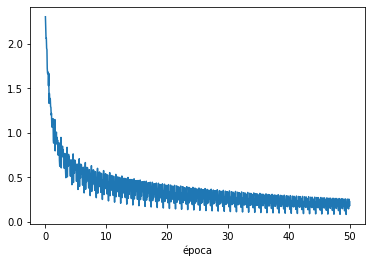

In [13]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

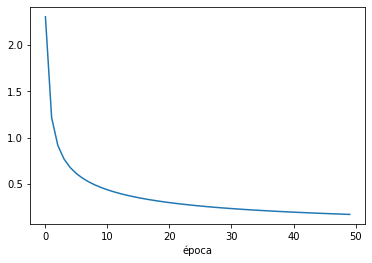

In [14]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [15]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

loader_val = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
with torch.no_grad():
  predictions_probs = []
  predictions = []
  targets = []
  for x_val, y_val in loader_val:
        inputs = x_val.view(-1, 28 * 28)
        outputs = model(inputs)
        preds = F.softmax(outputs, dim=1).max(dim=1)
        predictions_probs += preds.values.tolist()
        predictions += preds.indices.tolist()
        targets += y_val.tolist()

def show(image):
  plt.imshow(image.reshape(28, 28), cmap='gray')

df = pd.DataFrame({'prediction': predictions, 'target': targets, 'prob': predictions_probs})
df.head()

,prediction,target,prob
0,1,1,0.955682
1,3,3,0.943764
2,1,1,0.990751
3,8,8,0.912813
4,3,3,0.941401


prediction    2.00000
target        2.00000
prob          0.99999
Name: 183, dtype: float64


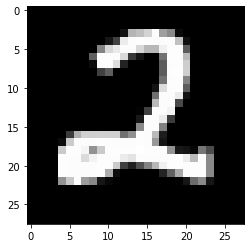

In [17]:
# Qual é a amostra classificada corretamente, com maior probabilidade?
idx = df.query('prediction == target')['prob'].sort_values().idxmax()
print(df.iloc[idx])
show(dataset_train[idx][0])

prediction    8.00000
target        3.00000
prob          0.85305
Name: 271, dtype: float64


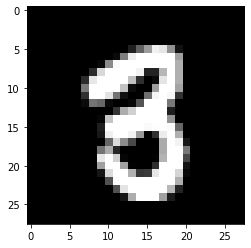

In [18]:
# Qual é a amostra classificada erradamente, com maior probabilidade?
idx = df.query('prediction != target')['prob'].sort_values().idxmax()
print(df.iloc[idx])
show(dataset_train[idx][0])

prediction    2.000000
target        2.000000
prob          0.335326
Name: 532, dtype: float64


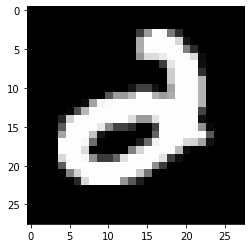

In [19]:
# Qual é a amostra classificada corretamente, com menor probabilidade?
idx = df.query('prediction == target')['prob'].sort_values().idxmin()
print(df.iloc[idx])
show(dataset_train[idx][0])

prediction    8.000000
target        5.000000
prob          0.289214
Name: 68, dtype: float64


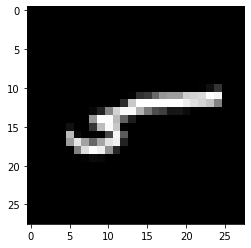

In [20]:
# Qual é a amostra classificada erradamente, com menor probabilidade?
idx = df.query('prediction != target')['prob'].sort_values().idxmin()
print(df.iloc[idx])
show(dataset_train[idx][0])

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.


In [21]:
import itertools
from collections import Counter

class WeightedDataLoader(DataLoader):
  def __init__(self, dataset, class_weights, batch_size=1, shuffle=False):
    self.dataset = dataset

    min_weight = min(class_weights)
    class_reweighted = [int(weight/min_weight) for weight in class_weights]
    example_labels = [label for (example, label) in dataset]

    self.batch_size = batch_size
    self.shuffle = shuffle
    if shuffle:
      self.indices = torch.randperm(len(dataset))
    else:
      self.indices = torch.tensor(range(len(dataset)))
    
    self.indices = [[i] * class_reweighted[dataset[i.item()][1]] for i in self.indices]
    self.indices = list(itertools.chain(*self.indices))
  
  def __len__(self):
    return len(self.indices) // self.batch_size


class_weights = [0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

loader_train = WeightedDataLoader(
    dataset_train,
    class_weights=class_weights,
    batch_size=batch_size,
    shuffle=True,
)
counter = Counter()
for (i, batch) in enumerate(loader_train):
  inputs, targets = batch
  # print(i, inputs.shape, targets)
  counter.update(targets.tolist())

total_count = sum(count for (label, count) in counter.items())
for (label, count) in counter.items():
  print(label, count / total_count)

1 0.01125
0 0.008557692307692308
5 0.007596153846153846
9 0.010288461538461538
6 0.008653846153846154
4 0.008461538461538461
2 0.713076923076923
3 0.21307692307692308
7 0.01
8 0.009038461538461539


In [22]:
loader_class_frequencies = [counter[label] / total_count for label in sorted(counter)]
np.allclose(loader_class_frequencies, class_weights, atol=0.05)

True